In [1]:
import pandas as pd
import psycopg2
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
%matplotlib inline
plt.style.use('ggplot')
fontsize = 40 # size for x and y ticks
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams.update({'font.size': fontsize})

con = psycopg2.connect(dbname='eicu', user='postgres', host='localhost', port=5432)



q2 = """select
    DISTINCT
  t.patientunitstayid as pid
  ,t.treatmentid as tid
  ,t.treatmentoffset as toffset
  ,%(phsid)s as phsid
from
	eicu_crd.treatment t
where t.treatmentstring like 'pulmonary|ventilation and oxygenation|prone position'
  and t.patientunitstayid in (select patientunitstayid from patient where patienthealthsystemstayid = %(phsid)s)
order by t.patientunitstayid"""

query =""" 
select 
	fi.pid,
    fi.lab_time,
    pa.res/fi.res as "PF ratio"
    ,%(phsid)s as phsid
from 
	(select
     	patientunitstayid as pid
     	,case
       when labresult is not NULL THEN labresult/100
       when labresult is NULL then replace(labresulttext,'%%','')::FLOAT/100
      end as res
     	,labresultoffset as lab_time
     from
     	eicu_crd.lab
     where 
     	patientunitstayid in (select patientunitstayid from patient
                            where patienthealthsystemstayid = %(phsid)s )
     	and labname = 'FiO2') as fi
     ,(select 
      	patientunitstayid as pid
      	,labresult as res
      	,labresultoffset as lab_time
      from
      	eicu_crd.lab
      where
      	patientunitstayid in (select patientunitstayid from patient
                            where patienthealthsystemstayid = %(phsid)s)
      	and labname = 'paO2') as pa
where pa.lab_time = fi.lab_time
and pa.pid = fi.pid
order by pa.lab_time"""

q3 = """
    select distinct patientunitstayid from patient
    where patienthealthsystemstayid = %(phsid)s
                            """

In [2]:
param = {'phsid': '2645908'}
tr = pd.read_sql_query(query, con, params=param)
tr2 = pd.read_sql_query(q2, con, params=param)
df3 = tr.merge(tr2, how='left', on=['phsid']).copy()
# df3.drop_duplicates(keep='first',inplace=True)
# tr3 = pd.read_sql_query(q3, con, params=param)
# tr3
df3['closed'] = ((df3['toffset'] - df3['lab_time'])/60).astype(float)

df3[['phsid','lab_time','PF ratio','toffset','closed']]


,phsid,lab_time,PF ratio,toffset,closed
0,2645908,-76,360.000000,8339,140.250000
1,2645908,-76,360.000000,5549,93.750000
2,2645908,-76,360.000000,7768,130.733333
3,2645908,-76,360.000000,7765,130.683333
4,2645908,-76,360.000000,6871,115.783333
5,2645908,-76,360.000000,1971,34.116667
6,2645908,-76,360.000000,2645,45.350000
7,2645908,732,59.000000,8339,126.783333
8,2645908,732,59.000000,5549,80.283333
9,2645908,732,59.000000,7768,117.266667


In [3]:
tr.sort_values('lab_time',inplace=True)
tr2.sort_values('toffset',inplace=True)



df2 = pd.merge_asof(tr2[['toffset']],tr[['lab_time','PF ratio']], right_on='lab_time', left_on='toffset', direction='backward').copy()
df2.rename(columns={"PF ratio": "Before"},inplace=True) 
df2['time_before'] = ((df2['toffset'] - df2['lab_time'])/60).astype(float)
df2

,toffset,lab_time,Before,time_before
0,1971,1934,108.888889,0.616667
1,2645,2350,164.000000,4.916667
2,5549,5217,156.666667,5.533333
3,6871,6540,176.000000,5.516667
4,7765,6540,176.000000,20.416667
5,7768,6540,176.000000,20.466667
6,8339,8124,190.000000,3.583333


In [4]:
df4 = pd.merge_asof(tr2[['toffset']],tr[['lab_time','PF ratio']], right_on=['lab_time'], left_on='toffset', direction='forward').copy()
df4.rename(columns={"PF ratio": "After"},inplace=True) 
df4['time_after'] = ((df4['lab_time'] - df4['toffset'])/60).astype(float)
df4

,toffset,lab_time,After,time_after
0,1971,2110,158.750000,2.316667
1,2645,2801,91.428571,2.600000
2,5549,5852,136.000000,5.050000
3,6871,8124,190.000000,20.883333
4,7765,8124,190.000000,5.983333
5,7768,8124,190.000000,5.933333
6,8339,9340,150.000000,16.683333


In [5]:
df7 = pd.merge(df2[['toffset','Before','time_before']],df4[['toffset','After','time_after']],on='toffset').copy()
df7 = df7[~(df7['After'].isnull()) & ~(df7['Before'].isnull())]
df7['pf delta'] = ((df7['After'] - df7['Before'])).astype(int)
df7

,toffset,Before,time_before,After,time_after,pf delta
0,1971,108.888889,0.616667,158.750000,2.316667,49
1,2645,164.000000,4.916667,91.428571,2.600000,-72
2,5549,156.666667,5.533333,136.000000,5.050000,-20
3,6871,176.000000,5.516667,190.000000,20.883333,14
4,7765,176.000000,20.416667,190.000000,5.983333,14
5,7768,176.000000,20.466667,190.000000,5.933333,14
6,8339,190.000000,3.583333,150.000000,16.683333,-40


In [6]:
df8 = df3[['PF ratio','lab_time','toffset']].drop_duplicates()

defulat_tol = 24
df8 = df8[np.abs(df8['lab_time']-df8['toffset'])<defulat_tol*60]

df8.reset_index(inplace=True,drop=True)


In [7]:
def extract_trend(rel_dict):
    trend_dict = {}
    for key, value in rel_dict.items():
        if len(value['PF ratio']) <= 1:
            trend_dict[key] = {'trend': 'single','tol': defulat_tol}
        elif value['PF ratio'].is_monotonic_decreasing:
            trend_dict[key] = {'trend':'decreasing','tol': defulat_tol}
        elif value['PF ratio'].is_monotonic_increasing:
            trend_dict[key] = {'trend': 'increasing','tol': defulat_tol}       
        else:
            for tol in [20,18,16,12,8]:
                temp = value[value['offset'] < tol*60]
                if len(temp) < 1:
                    print(value)
                    break;
                elif len(temp) == 1:
                    trend_dict[key] = {'trend': 'single','tol': tol}
                    break;
                elif temp['PF ratio'].is_monotonic_decreasing:
                    trend_dict[key] = {'trend':'decreasing','tol': tol}
                    break;
                elif temp['PF ratio'].is_monotonic_increasing:
                    trend_dict[key] = {'trend': 'increasing','tol': tol}
                    break;
    temp_df = pd.DataFrame(data=trend_dict)
    trend_df = temp_df.transpose()
#     trend_df.reset_index(inplace=True)
#     trend_df.rename(columns={"index": "toffset"},inplace=True) 
    return trend_df.copy()

In [8]:
df9 = df8[df8['lab_time']<df8['toffset']].copy()
df9['offset'] = ((df9['toffset'] - df9['lab_time'])).astype(int)
df9.sort_values(['toffset','lab_time'],inplace=True)

gb9 = df9.groupby('toffset')    
dict_before = {x:gb9.get_group(x) for x in gb9.groups}

df_before = extract_trend(dict_before)


df_before

,tol,trend
2645,8,decreasing
5549,24,increasing
6871,24,increasing
7765,24,single
7768,24,single
8339,24,single


In [9]:
df10 = df8[df8['lab_time']>df8['toffset']].copy()
df10['offset'] = ((df10['lab_time'] - df10['toffset'])).astype(int)
df10.sort_values(['toffset','lab_time'],inplace=True)

gb10 = df10.groupby('toffset')    
dict_after = {x:gb10.get_group(x) for x in gb10.groups}

df_after = extract_trend(dict_after)



In [10]:

df_results = pd.merge(df_before,df_after,right_index=True,left_index=True,how='outer',suffixes=('_before','_after'))
df_results[(df_results['trend_before']!='single') & ~(df_results['trend_before'].isnull()) 
           & (df_results['trend_after']!='single') & ~(df_results['trend_after'].isnull()) ]


,tol_before,trend_before,tol_after,trend_after
2645,8,decreasing,16,decreasing
5549,24,increasing,24,increasing


In [11]:
df_results

,tol_before,trend_before,tol_after,trend_after
2645,8,decreasing,16,decreasing
5549,24,increasing,24,increasing
6871,24,increasing,24,single
7765,24,single,24,single
7768,24,single,24,single
8339,24,single,24,single


In [12]:
retult_dict = {}
for key in list(df_results.index):
    try:
#         value[value['offset'] < tol*60]
        before = dict_before[key]['PF ratio'].mean()
        after = dict_after[key]['PF ratio'].mean()
        delta = after - before
        retult_dict[key] = {'result': delta}
    except KeyError:
        print("missing data for prone change: {}".format(key))
result = pd.DataFrame(data=retult_dict)
result.transpose()

,result
2645,-12.813591
5549,13.291667
6871,34.000000
7765,14.000000
7768,14.000000
8339,-40.000000


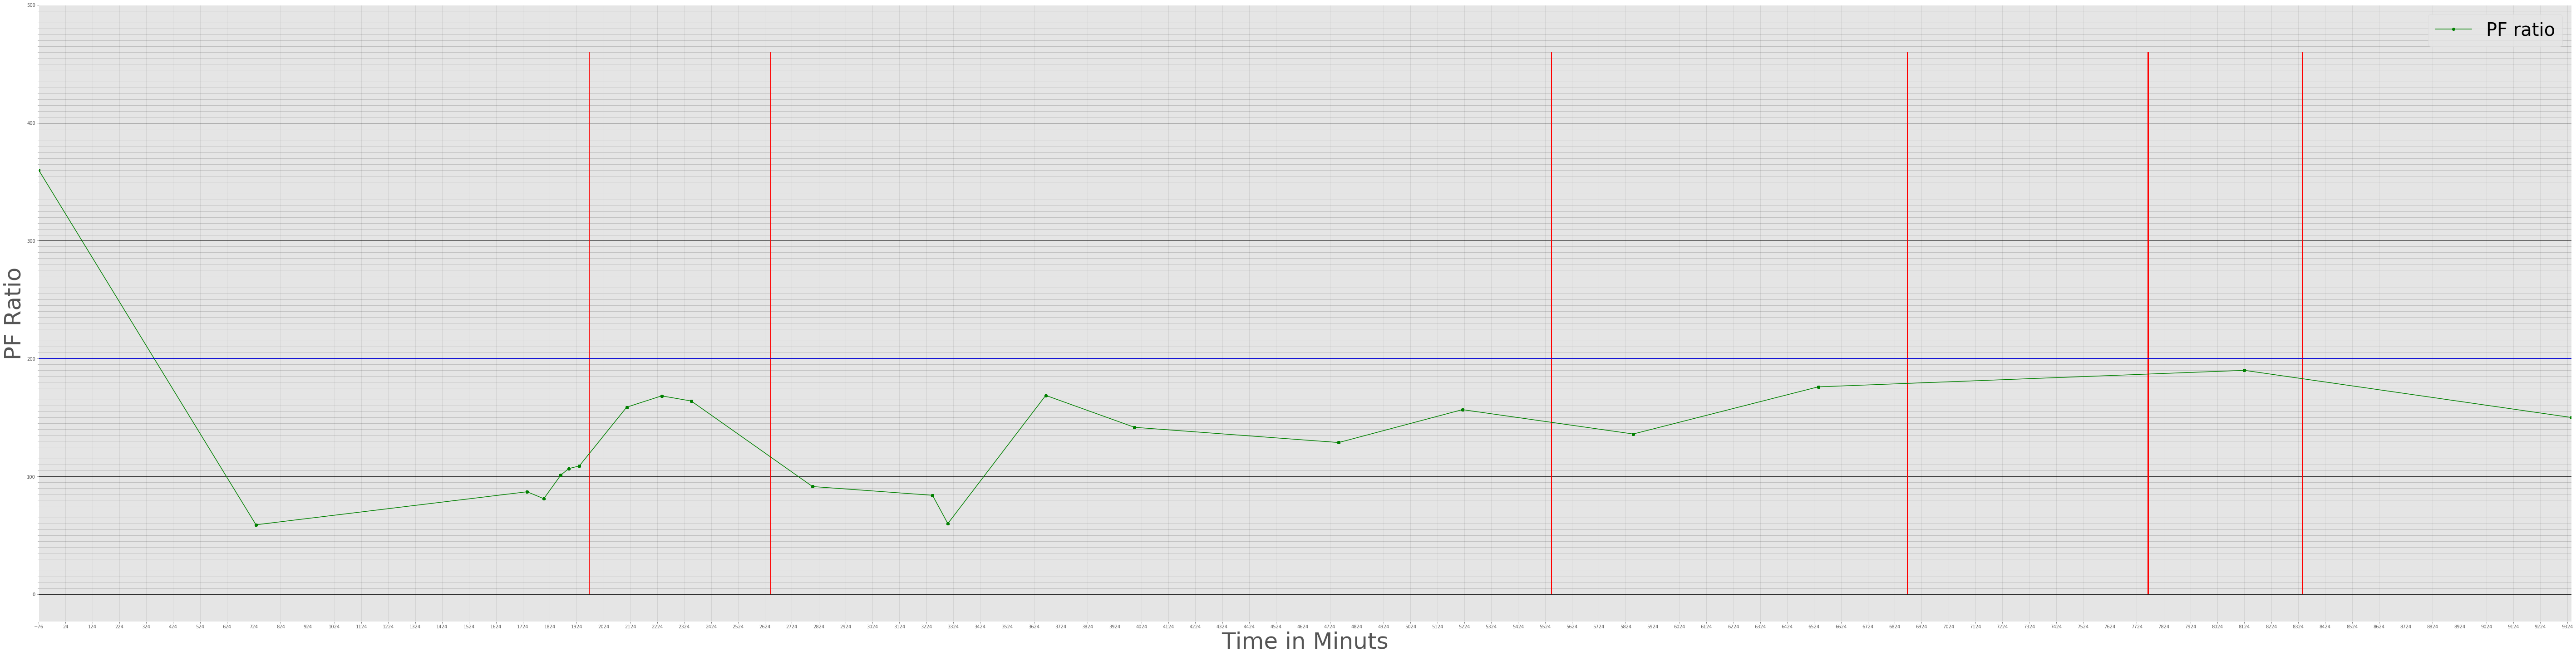

In [13]:
df5 = df3[['PF ratio','lab_time','toffset']].copy()
df6 = df3[['PF ratio', 'toffset']].copy()
%matplotlib inline

min_val = min(min(df5[['toffset','lab_time']].min()),0)
minor_ticks = np.arange(0, 501, 5)
x_major_ticks = np.arange(min_val, df5[['lab_time']].max(), 100)


ax=df5.plot(x=['lab_time'],y='PF ratio', color='g',marker='o', label='PF ratio',figsize=(100,25))
ax.vlines(x=df5['toffset'],ymin=0,ymax=460, color='r', label='prone change')
ax.axhline(y=200,color='b')
ax.set_xlabel('Time in Minuts',fontsize=50)
ax.set_ylabel('PF Ratio', fontsize=50)
ax.set_yticks(minor_ticks,minor=True)
ax.set_xticks(x_major_ticks)
ax.yaxis.grid(True, linestyle='-', which='major', color='black',
               alpha=1)
ax.yaxis.grid(True, linestyle='-', which='minor', color='black',
               alpha=0.2)
ax.xaxis.grid(True, linestyle='-', which='major', color='black',
               alpha=0.1)
plt.show()